In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jaxley as jx

from jaxley import Compartment
from jaxley_mech.channels.tfmc90 import Phototransduction

In [2]:
from jaxley_mech.channels.kwu09 import Leak, Kv, Ca, CaNernstReversal, KCa, ClCa, Hyper, CaPump

###  Voltage Clamp (Fig. 3)

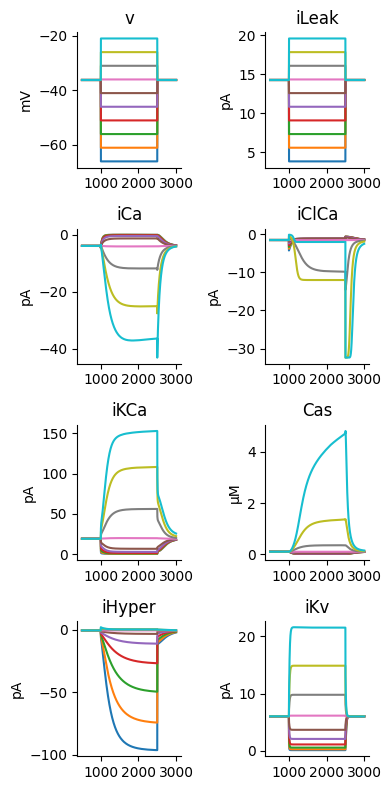

In [3]:
to_records = ["v", "Cas", "iCa", "iClCa", "iKCa", "iLeak", "iHyper", 'iKv']
mosaic = [["v", "iLeak"], ["iCa", "iClCa"], ["iKCa", "Cas"], ['iHyper', 'iKv']]

params = {
    "length": 10,
    "radius": 5,
    "capacitance": 30.0,
    "axial_resistivity": 34.5,
    "v": -36.2,
}

fig, ax = plt.subplot_mosaic(mosaic, figsize=(4, 8))

V_steps = jnp.arange(-66, -20, 5)
for v_step in V_steps:

    cell = Compartment()
    cell.insert(Kv())
    cell.insert(Hyper())
    cell.insert(Ca())
    cell.insert(ClCa())
    cell.insert(KCa())
    cell.insert(CaPump())
    cell.insert(CaNernstReversal())
    cell.insert(Leak())

    for name, param in params.items():
        cell.set(name, param)

    cell.init_states()

    for rec in to_records:
        cell.record(rec, verbose=False)

    pre_vc_time = 1000  # ms
    vc_on_time = 1500  # ms
    total_time = 4000 # ms
    dt = 0.01 # ms, yield nan if larger than 0.01
    time_steps = int(total_time / dt)
    time = jnp.linspace(0, total_time, time_steps)

    v = jnp.zeros(time_steps) - 36.2
    vc_on = int(pre_vc_time / dt)
    vc_off = int((pre_vc_time + vc_on_time) / dt)
    padding = int(500/dt)
    v = v.at[vc_on:vc_off].set(v_step)
    cell.external_states = {
        "v": v.reshape(-1, 1),
    }

    s = jx.integrate(cell, delta_t=dt, t_max=total_time)

    for i, rec in enumerate(to_records):
        ax[rec].plot(time[vc_on-padding:vc_off+padding], s[i].T[:-1][vc_on-padding:vc_off+padding])
        ax[rec].set_title(rec)
        ax[rec].spines["top"].set_visible(False)
        ax[rec].spines["right"].set_visible(False)
        if rec == "Cas":
            ax[rec].set_ylabel("μM")
        elif rec == "v":
            ax[rec].set_ylabel("mV")
        else:
            ax[rec].set_ylabel("pA")

fig.tight_layout()

## Light response (Fig. 1)

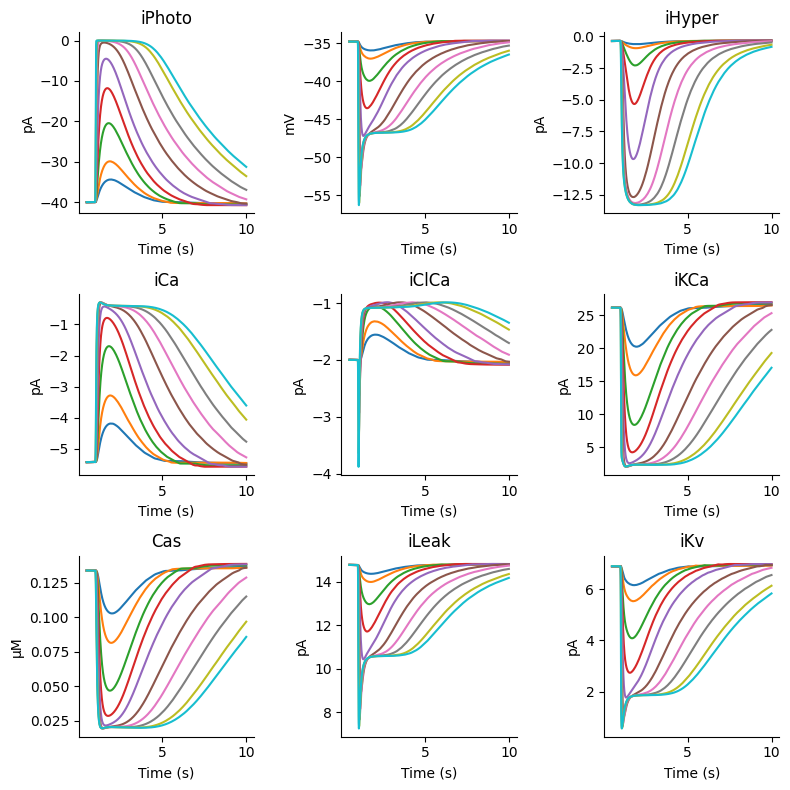

In [4]:
to_records = ["v", "iPhoto", "Cas", "iCa", "iClCa", "iKCa", "iLeak", "iHyper", 'iKv']
mosaic = [["iPhoto", "v", "iHyper"], ["iCa", "iClCa", "iKCa"], ["Cas", "iLeak", "iKv"]]

params = {
    "length": 10,
    "radius": 5,
    "capacitance": 0.02, # nF
    # "axial_resistivity": 34.5,
    "v": -36.2,
}

fig, ax = plt.subplot_mosaic(mosaic, figsize=(8, 8))

for intensity in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]:

    cell = Compartment()
    cell.insert(Kv())
    cell.insert(Hyper())
    cell.insert(Ca())
    cell.insert(ClCa())
    cell.insert(KCa())
    cell.insert(CaPump())
    cell.insert(CaNernstReversal())
    cell.insert(Leak())
    cell.insert(Phototransduction())

    for name, param in params.items():
        cell.set(name, param)

    cell.init_states()

    for rec in to_records:
        cell.record(rec, verbose=False)

    pre_light_time = 1000  # ms
    light_on_time = 20  # ms
    total_time = 10000 # ms
    dt = 0.01 # ms
    time_steps = int(total_time / dt)
    time = jnp.linspace(0, total_time, time_steps)

    Jhv = jnp.zeros(time_steps)
    light_on = int(pre_light_time / dt)
    light_off = int((pre_light_time + light_on_time) / dt)
    padding = int(500/dt)
    Jhv = Jhv.at[light_on:light_off].set(intensity)
    cell.external_states = {
        "Phototransduction_Jhv": Jhv.reshape(-1, 1),
    }

    s = jx.integrate(cell, delta_t=dt, t_max=total_time)

    for i, rec in enumerate(to_records):
        ax[rec].plot(time[light_on-padding:]/1000, s[i].T[:-1][light_on-padding:])
        ax[rec].set_title(rec)
        ax[rec].set_xlabel("Time (s)")
        ax[rec].spines["top"].set_visible(False)
        ax[rec].spines["right"].set_visible(False)
        if rec == "Cas":
            ax[rec].set_ylabel("μM")
        elif rec == "v":
            ax[rec].set_ylabel("mV")
        else:
            ax[rec].set_ylabel("pA")

fig.tight_layout()

Not exactly the same as Fig. 1 in the paper, but the dynamics are close. The most obvious divergence is the iClCa, but it's more likely due to the Cas (CaPump). 

In [5]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p jaxley_mech

Last updated: 2024-06-10 17:39:50CEST

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.21.0

jaxley_mech: 0.0.1

matplotlib: 3.8.3
jaxley    : 0.0.0
jax       : 0.4.26

Watermark: 2.4.3

